In [1]:
import os
import pandas as pd
import joblib
import numpy as np
from operator import add
from functools import partial
from typing import TypedDict, List, Tuple, Literal, Dict, Annotated
from langgraph.graph import StateGraph, END
from langchain_ollama import ChatOllama, OllamaEmbeddings
from langchain_community.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document
from langchain.document_loaders import PyPDFLoader, CSVLoader, TextLoader
from langchain.retrievers import BM25Retriever, EnsembleRetriever, ContextualCompressionRetriever
from langchain.retrievers.document_compressors import EmbeddingsFilter
from pydantic import BaseModel, Field

In [2]:
MODEL = 'granite4:latest'
llm = ChatOllama(model=MODEL, num_ctx=15768)
embeddings = OllamaEmbeddings(model=MODEL)

In [ ]:
# df = pd.read_csv('data/data2.csv')
# data_imp = df[['Study Title', 'Study URL', 'Study Status', 'Brief Summary', 'Study Results',
#                'Conditions', 'Interventions', 'Primary Outcome Measures', 'Secondary Outcome Measures',
#                'Other Outcome Measures']].sample(frac=0.4)
# with open('data/data2_processed.txt', 'w+', encoding='utf-8') as f:
#     for _, row in data_imp.iterrows():
#         for col in data_imp.columns:
#             f.write(f"{col}: {row[col]}\n")
#         f.write('\n\n')

# df = pd.read_csv('data/data1.csv')
# with open('data/abstracts.txt', 'w+', encoding='utf-8') as f:
#     for abstract in df['abstract_text'].sample(frac=0.4):
#         f.write(abstract + '\n\n')


In [ ]:
# book1 = PyPDFLoader('data/book1.pdf').load()
# book2 = PyPDFLoader('data/book2.pdf').load()
# abs1 = TextLoader('data/abstracts.txt', encoding='utf-8').load()
# data2 = TextLoader('data/data2_processed.txt', encoding='utf-8').load()

# text_splitter = RecursiveCharacterTextSplitter(chunk_size=6000, chunk_overlap=1500)
# documents = []
# for doc in [book1, book2]:
#     documents.extend(text_splitter.split_documents(doc))

# text_splitter_5k = RecursiveCharacterTextSplitter(chunk_size=6000, chunk_overlap=1500)
# for doc in [abs1, data2]:
#     documents.extend(text_splitter_5k.split_documents(doc))

In [3]:
# len(documents) # 5815

In [4]:
# from tqdm.auto import tqdm
# import numpy as np

# embedded_docs = []
# for doc in tqdm(documents):
#     vector = embeddings.embed_documents([doc.page_content])[0]
#     embedded_docs.append((doc, vector))

In [5]:
# import joblib
# joblib.dump(embedded_docs, 'data/embedded_docs.joblib')
# len(embedded_docs)

In [6]:
# embedded_docs = np.load('data/embedded_docs.npy', allow_pickle=True)
loaded_docs = joblib.load('data/embedded_docs.joblib')
docs = [d for d, _ in loaded_docs]
vectors = [v for _, v in loaded_docs]

In [8]:
len(vectors[0]), len(vectors)

(2560, 5815)

In [9]:
with open('data/all_content.txt', 'w+', encoding='utf-8') as f:
    f.write(''.join([d.page_content for d in docs]))

In [10]:
normalized_docs = [(d, v/np.linalg.norm(v)) for d, v in loaded_docs]

In [11]:
research_data = [d for d in normalized_docs if d[0].metadata['source'] == 'data/abstracts.txt']
book_data = [d for d in normalized_docs if d[0].metadata['source'] in ['data/book1.pdf', 'data/book2.pdf']]
clinical_data = [d for d in normalized_docs if d[0].metadata['source'] == 'data/data2_processed.txt']

In [12]:
len(research_data), len(book_data), len(clinical_data)

(2462, 51, 3302)

In [13]:
def build_retriever(data: List[tuple[Document, List[float]]], k:int = 10, weights: List[float] = [0.6, 0.4]) -> ContextualCompressionRetriever:
    vector_store  = FAISS.from_embeddings(text_embeddings=[(d.page_content, v) for d, v in data], 
                                          embedding=embeddings,
                                          metadatas=[d.metadata for d, _ in data])
    vector_retriever = vector_store.as_retriever(k=k)

    keyword_retriever = BM25Retriever.from_documents([d for d , _ in data])
    keyword_retriever.k = k

    ensemble_retriever = EnsembleRetriever(retrievers=[vector_retriever, keyword_retriever],
                                           weights=weights)

    embedding_filter = EmbeddingsFilter(embeddings=embeddings, similarity_threshold=0.52)
    filtered_retriever = ContextualCompressionRetriever(base_compressor=embedding_filter, base_retriever=ensemble_retriever)

    return filtered_retriever

research_retriever = build_retriever(research_data, weights=[0.7, 0.3])
book_retriever = build_retriever(book_data, weights=[0.5, 0.5])
clinical_retriever = build_retriever(clinical_data, weights=[0.6, 0.4])

In [14]:
# clinical_retriever.invoke("What are the steps to treat type 2 diabetes?")
retrievers = {
    'research': research_retriever,
    'book': book_retriever,
    'clinic': clinical_retriever
}

In [15]:
class MasterAgentState(TypedDict):
    question: str
    queries: Dict[Literal['clinic', 'research', 'book'], str]
    contexts: Annotated[List[Tuple[str, str]], add]
    answer: str
    
class MasterQuery(BaseModel):
    queries: Dict[Literal['clinic', 'research', 'book'], str] = Field(description="Dictionary of {agent_type : query}. query will be passed to the vector store of respective agent_type")

In [16]:
query = "What are steps to treat diabetes 2?"

def master_query_node(state: MasterAgentState) -> MasterAgentState:
    query = state['question']

    prompt_master = r"""
You are a **Master Routing Agent** responsible for delegating a user's medical question to the most relevant specialized Worker Agents. 
Each Worker Agent has access to a unique document vector store, all related to **diabetes management**.

Your job:
1. Analyze the question’s intent (clinical outcomes, research findings, or practical management).
2. Decide which Worker Agent(s) should receive the query. 
   - You may select one, two, or all three agents, but include each agent only once.
3. Generate **worker-specific, context-rich sub-queries** that use domain-relevant terminology, synonyms, and keywords found or implied in the question.

Available Worker Agents:
- **clinic** → Clinical trials, outcomes, interventions, patient cohorts, and treatment efficacy.
- **research** → Biomedical studies, molecular mechanisms, pharmacological actions, and evidence synthesis.
- **book** → Medical textbooks, care guidelines, information about diabetes disease and medication and lifestyle management practices for diabetes.

If unsure, include all three agents to maximize coverage, but customize each sub-query to the data type they handle.

Output format:
{
  "clinic": "...query tailored for clinical data...",
  "research": "...query tailored for research abstracts...",
  "book": "...query tailored for practical/lifestyle information..."
}

When generating queries:
- Use worker-specific terminology (e.g., “trial outcomes” for clinic, “mechanisms” for research, “self-care” for book).
- Rephrase or expand user questions with relevant keywords (e.g., drug names, biomarkers, outcome measures).
- Keep queries concise but information-rich.
- During query formation add domain-related synonyms and related terms to enhance retrieval effectiveness.

Query:
""" + query


    initial_agent = llm.with_structured_output(MasterQuery)
    res = initial_agent.invoke(input=prompt_master)
    assert isinstance(res, MasterQuery), "Master query Failed"
    return {**state, 'queries': res.queries, 'contexts': [] }



def worker_node(state: MasterAgentState, worker_name: Literal['clinic', 'research', 'book']):
    query = state["queries"].get(worker_name)
    if query is None:
        return {**state}
    retriever = retrievers[worker_name]
    docs = retriever.invoke(query)
    context_chunks = []
    for doc in docs:
        source_info = doc.metadata['source']
        context_chunks.append(f"Source: {source_info}\nContent: {doc.page_content}")
    context = "\n\n---\n\n".join(context_chunks)
    return {'contexts': [(worker_name, context)]}


def master_synthesizer_node(state: MasterAgentState) -> MasterAgentState:
    question = state["question"]
    context_str = ""
    for agent_name, context in state['contexts']:
        context_str += f"--- Context from {agent_name} ---\n{context}\n\n"
    prompt = f"""
    You are an expert medical research assistant. You have received context from several specialized agents.
    - Prioritize evidence that directly addresses the user's question.
    - Explicitly mention which source each claim is drawn from.
    - Do NOT invent or infer beyond what is supported by the provided context.
    - If there is conflicting information, state it clearly.

    {context_str}

    Original Question: {question}
    Final, evidence-based answer:
    """

    
    res = llm.invoke(prompt).content
    assert isinstance(res, str), "Final answer generation failed"
    return {**state, "answer": res}

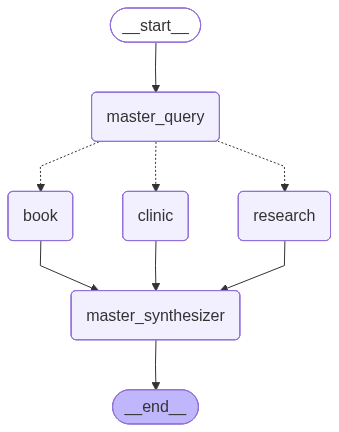

In [17]:
def route_to_workers(state: MasterAgentState) -> List[str]:
    return list(state["queries"].keys())

graph = StateGraph(MasterAgentState)

graph.set_entry_point('master_query')
graph.add_node("master_query", master_query_node)

graph.add_node('clinic', partial(worker_node, worker_name='clinic'))
graph.add_node('research', partial(worker_node, worker_name='research'))
graph.add_node('book', partial(worker_node, worker_name='book'))

graph.add_node('master_synthesizer', master_synthesizer_node)

graph.add_conditional_edges(
    "master_query",
    route_to_workers,
    {
        'clinic': 'clinic',
        'research': 'research',
        'book': 'book'
    }
)

graph.add_edge('clinic', 'master_synthesizer')
graph.add_edge('research', 'master_synthesizer')
graph.add_edge('book', 'master_synthesizer')
graph.set_finish_point('master_synthesizer')


app = graph.compile()
app

In [22]:
def ask_question(question: str) -> MasterAgentState:
    initial_state: MasterAgentState = {
        'question': question,
        'queries': {},
        'contexts': [],
        'answer': ''
    }
    final_state = app.invoke(initial_state)
    return final_state

In [416]:
res = ask_question("What are steps to treat diabetes 2?")
print(res['answer'])

**Steps to Treat Type 2 Diabetes**

1. **Lifestyle Modifications**
   - **Diet**: Adopt a balanced diet rich in whole grains, lean proteins, healthy fats (like those found in olive oil and nuts), fruits, and vegetables. Limit intake of refined sugars and saturated fats.
   - **Physical Activity**: Engage in regular physical activity such as walking, cycling, swimming, or strength training for at least 150 minutes per week.
   - **Weight Management**: Achieve and maintain a healthy weight through diet and exercise.

2. **Medications**
   - **Metformin**: Often the first-line medication to help control blood sugar levels by reducing glucose production in the liver and improving insulin sensitivity.
   - **Sulfonylureas (e.g., Glipizide, Glyburide)**: Stimulate the pancreas to produce more insulin.
   - **Thiazolidinediones (e.g., Pioglitazone, Rosiglitazone)**: Improve insulin sensitivity in muscle and fat cells.
   - **DPP-4 Inhibitors (e.g., Sitagliptin, Saxagliptin)**: Help increase l

In [417]:
res['queries']

{'clinic': 'What are the recommended treatment strategies for type 2 diabetes, including clinical trial outcomes and efficacy of interventions?',
 'research': 'How do recent studies elucidate the molecular mechanisms underlying type 2 diabetes pathophysiology and therapeutic targets?',
 'book': 'What practical lifestyle management steps, medication regimens, and self-care practices are outlined in medical guidelines for managing type 2 diabetes?'}

In [418]:
res['contexts']

[('book',
  'Source: data/book2.pdf\nContent: Type 2 Diabetes Mellitus \nVA Office of Patient Centered Care and Cultural Transformation \nPage 2 of 9 \nVegetarian diet.  Plant-based diets may be associated with lower circulating levels of \ninsulin-like growth factor (IGF-1).  They have been found to lead to a 1.23% reduction in \nHgbA1C, according to one randomized controlled trial (RCT).[5]  \nVery Low Energy Diets (VLEDs).  A 2020 review and meta-analysis of intermittent and \ncontinuous VLEDs suggested that this approach to eating is an effective therapy for rapid \nweight loss and glycemic control, as well as improved lipid metabolism, specifically in \nT2DM populations that are overweight and obese.  Further research is still required to \ndetermine long-term benefits or risks of this dietary choice.[6] \nPlant-Based diets:  A 2018 review of studies related to the implementation of plant-based \ndiets with people diagnosed with T2DM showed some statistically significant health \n

In [419]:
res1 = ask_question('AWhat was the primary objective of the mHealth Insulin Titration and Management (iSage) study, and how did the investigators plan to measure its effectiveness?')

print(res1['answer'])

The primary objective of the mHealth Insulin Titration and Management (iSAGE) study was to evaluate the effectiveness of a mobile health (mHealth) intervention in improving glycemic control among adults with type 2 diabetes. The investigators planned to measure its effectiveness through several key outcomes:

1. **Glycated Hemoglobin (HbA1c) Levels**: This is a primary indicator of long-term blood sugar control. A reduction in HbA1c levels would suggest improved glycemic management.

2. **Adherence to Insulin Regimen**: The study aimed to assess how well participants adhered to their insulin dosing schedule as prescribed by healthcare providers, which can significantly impact glycemic control.

3. **Quality of Life (QoL)**: Assessments were conducted to determine improvements in the overall quality of life related to diabetes management, including physical, emotional, and social aspects.

4. **Adherence to Treatment**: This included monitoring how consistently participants followed the

In [420]:
res1['queries']

{'clinic': 'What were the primary objectives and key efficacy measures for the iSage clinical trial investigating mHealth insulin titration in type 1 diabetes?',
 'research': 'How was the investigational design, endpoints, and biomarker analysis structured to assess the effectiveness of mobile health interventions for insulin management in individuals with type 1 diabetes?',
 'book': 'What are evidence-based strategies for using digital tools to optimize insulin dosing regimens and glycemic control outcomes in patients with type 1 diabetes?'}

In [421]:
res1['contexts']

[('book',
  'Source: data/book2.pdf\nContent: Type 2 Diabetes Mellitus \nVA Office of Patient Centered Care and Cultural Transformation \nPage 2 of 9 \nVegetarian diet.  Plant-based diets may be associated with lower circulating levels of \ninsulin-like growth factor (IGF-1).  They have been found to lead to a 1.23% reduction in \nHgbA1C, according to one randomized controlled trial (RCT).[5]  \nVery Low Energy Diets (VLEDs).  A 2020 review and meta-analysis of intermittent and \ncontinuous VLEDs suggested that this approach to eating is an effective therapy for rapid \nweight loss and glycemic control, as well as improved lipid metabolism, specifically in \nT2DM populations that are overweight and obese.  Further research is still required to \ndetermine long-term benefits or risks of this dietary choice.[6] \nPlant-Based diets:  A 2018 review of studies related to the implementation of plant-based \ndiets with people diagnosed with T2DM showed some statistically significant health \n

In [363]:
res2 = ask_question('What was the main purpose of the Trial in Diabetic Patients to Assess Effect of CE-326,597 on Glucose Control and Body Weight, and how did researchers evaluate its outcomes alongside relevant lifestyle and self-care recommendations for diabetes management?')
print(res2['answer'])

The main purpose of the trial in diabetic patients to assess the effect of CE-326,597 on glucose control and body weight was to determine the effectiveness of this medication in improving glycemic control (measured by HbA1c) and reducing body weight among individuals with type 2 diabetes. Researchers evaluated outcomes through primary outcome measures such as changes in HbA1c levels at 12 months, alongside secondary outcomes including weight loss measured by percent change in body weight over the same period.

**Source:** data/data2_processed.txt


In [343]:
res2['queries']

{'clinic': 'What was the main purpose of the trial in diabetic patients assessing the effect of CE-326,597 on glucose control and body weight, including primary outcome measures and statistical analysis?',
 'research': 'How did researchers evaluate the efficacy and safety of CE-326,597 in managing glycemic control and adiposity among participants with type 2 diabetes, focusing on mechanistic pathways and pharmacodynamic endpoints?',
 'book': 'What are evidence-based lifestyle and self-care recommendations for individuals with diabetes during or after taking CE-326,597, including dietary guidelines, physical activity strategies, blood glucose monitoring practices, and patient education resources?'}

In [344]:
res2['contexts']

[('book',
  'Source: data/book2.pdf\nContent: Type 2 Diabetes Mellitus \nVA Office of Patient Centered Care and Cultural Transformation \nPage 2 of 9 \nVegetarian diet.  Plant-based diets may be associated with lower circulating levels of \ninsulin-like growth factor (IGF-1).  They have been found to lead to a 1.23% reduction in \nHgbA1C, according to one randomized controlled trial (RCT).[5]  \nVery Low Energy Diets (VLEDs).  A 2020 review and meta-analysis of intermittent and \ncontinuous VLEDs suggested that this approach to eating is an effective therapy for rapid \nweight loss and glycemic control, as well as improved lipid metabolism, specifically in \nT2DM populations that are overweight and obese.  Further research is still required to \ndetermine long-term benefits or risks of this dietary choice.[6] \nPlant-Based diets:  A 2018 review of studies related to the implementation of plant-based \ndiets with people diagnosed with T2DM showed some statistically significant health \n

In [3]:
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness, ContextRecall, ContextPrecision, ContextPrecision
from ragas import EvaluationDataset
from tqdm.auto import tqdm

c:\Users\dasha\Desktop\Projects\rag-agent-adv\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
questions = [
    # Q1 & Q2 from earlier
    "What was the primary objective of the mHealth Insulin Titration and Management (iSage) study?",
    "What was the main purpose of the trial evaluating CE-326,597 in diabetic patients?",

    # New ones
    "What is the main focus of the Dissecting Host-microbiome Modifiers of Type 2 Diabetes Risk study?",
    "What procedure is used for sample collection in the host-microbiome study?",
    "What is the primary outcome measure of the host-microbiome study?",
    "What type of patients are being recruited for the host-microbiome modifiers of diabetes risk study?",
    "What are the primary and secondary outcomes of the iPATH study on type 2 diabetes?",
    "What intervention is being implemented in the iPATH study?",
    "How long is the iPATH study expected to collect patient data?",
    "What was the main objective of the vildagliptin add-on insulin therapy study?",
    "What were the key efficacy measures in the vildagliptin trial?",
    "What were the key safety endpoints assessed in the vildagliptin study?",
    "How was glycemic control assessed in the vildagliptin insulin therapy trial?",
    "What is the gender distribution reported in the descriptive analysis of one of the studies?",
    "What was the observed correlation between bioavailable 25-hydroxyvitamin D and LL-37 levels?"
]

ground_truths = [
    # A1
    "The primary objective of the mHealth Insulin Titration and Management (iSage) study was to evaluate the effectiveness of a mobile health (mHealth) intervention in improving insulin management among patients with type 2 diabetes. The investigators planned to measure effectiveness through outcomes including adherence to medication, self-management behaviors, clinical outcomes such as HbA1c, user engagement with the app, cost-effectiveness, and safety.",

    # A2
    "The main purpose of the trial evaluating CE-326,597 was to assess its effect on glucose control and body weight among individuals with type 2 diabetes. Researchers measured changes in HbA1c levels, fasting plasma glucose, and postprandial glucose, along with secondary outcomes like weight change, BMI, and adherence to lifestyle practices.",

    # A3
    "The Dissecting Host-microbiome Modifiers of Type 2 Diabetes Risk study focuses on understanding how changes in gut microbiota composition contribute to the development of insulin resistance, glucose intolerance, and inflammation associated with type 2 diabetes.",

    # A4
    "The study uses endoscopy and duodenal biopsy procedures to collect gut microbiome and tissue samples for analysis.",

    # A5
    "The primary outcome measure is the microbial signature, which compares the bacterial profiles of subjects with and without type 2 diabetes after one week.",

    # A6
    "The study recruits individuals with type 2 diabetes and non-diabetic controls to analyze differences in gut microbiome composition and gut barrier function.",

    # A7
    "The iPATH study measures primary outcomes such as changes in hemoglobin A1c and the percentage of patients with poorly controlled diabetes (A1c > 9%) before and after a one-year practice transformation. No secondary outcome measures were listed.",

    # A8
    "The intervention in the iPATH study is a team-based, technology-enabled care model called the iPATH implementation approach.",

    # A9
    "The iPATH study will collect patient and clinic data for up to three years, with different institutions beginning the implementation in either year one or year two.",

    # A10
    "The vildagliptin add-on insulin therapy study aimed to assess the efficacy and safety of vildagliptin 50 mg twice daily as an add-on treatment to insulin, with or without metformin, in patients with type 2 diabetes inadequately controlled by insulin alone.",

    # A11
    "Key efficacy measures included change from baseline in HbA1c at 12 weeks, responder rates based on various HbA1c thresholds, and change from baseline in fasting plasma glucose.",

    # A12
    "Safety endpoints included the number of participants with hypoglycemic events, adverse events, serious adverse events, and deaths occurring during the 12-week treatment period.",

    # A13
    "Glycemic control was assessed using HbA1c and fasting plasma glucose (FPG) measurements taken at baseline and after 12 weeks, analyzed at a central laboratory using high-performance liquid chromatography.",

    # A14
    "The descriptive data showed that 40% of participants were male and 60% were female.",

    # A15
    "A positive correlation was observed between bioavailable 25-hydroxyvitamin D and LL-37 levels (Spearman = 0.44, p = 0.03), while total 25-hydroxyvitamin D was not correlated with LL-37."
]

dataset = []
for query, ground_truth in tqdm(zip(questions, ground_truths)):
    res = ask_question(query)
    dataset.append({
        'user_input': query,
        'retrieved_contexts': res['contexts'],
        'reference': ground_truth,
        'response': res['answer']
    })

15it [15:21, 61.46s/it]


In [ ]:
# joblib.dump(dataset, 'data/evaluation_dataset.joblib')

['data/evaluation_dataset.joblib']

In [4]:
import joblib
dataset = joblib.load('data/evaluation_dataset.joblib')

In [5]:
for d in dataset:
    # d['user_input'] = d['question']
    # d['response'] = d['answer']
    # d['reference'] = d['ground_truth']
    d['retrieved_contexts'] = [f"{agent}: {context}" for agent, context in d['retrieved_contexts'] if context.strip() != '']
    # del d['generated_queries']

In [6]:
dataset[4]

{'user_input': 'What is the primary outcome measure of the host-microbiome study?',
 'retrieved_contexts': ['book: Source: data/book1.pdf\nContent: Retrograde ejaculation\nIn retrograde ejaculation, all or part of the semen is ejaculated backward into the bladder rather than out of the penis. This \nhappens when certain muscles that open and close to allow passage of fluids inside the body don’t work correctly. The semen \nejaculated into the bladder does no harm and is eliminated during urination. \nSymptoms of retrograde ejaculation include:\n  • A small amount of discharge during sex\n  • Cloudy urine\n  • Infertility issues\nRetrograde ejaculation caused by nerve damage due to poor blood sugar control can be treated with medicine. \nWhat you can do to maintain your sexual health\nTo have a healthy and fulfilling life with type 2 diabetes and avoid potential sexual complications, it is important to eat right, \nexercise daily, track your blood sugar, and take medication if needed. \

In [7]:
evaluation_dataset = EvaluationDataset.from_list(dataset)

In [8]:
# from langchain_openai import  ChatOpenAI
# from dotenv import load_dotenv
# import os

# load_dotenv()

# eval_llm = ChatOpenAI(name='gpt-5-nano', temperature=0, api_key=os.getenv('OPENAI_API_KEY'))
# eval_llm

In [ ]:
evaluator_llm = LangchainLLMWrapper(llm)

result = evaluate(dataset=evaluation_dataset,metrics=[ContextPrecision(), ContextRecall()],
                  llm=evaluator_llm)
result

C:\Users\dasha\AppData\Local\Temp\ipykernel_21308\95131088.py:1: DeprecationWarning: LangchainLLMWrapper is deprecated and will be removed in a future version. Use llm_factory instead: from openai import OpenAI; from ragas.llms import llm_factory; llm = llm_factory('gpt-4o-mini', client=OpenAI(api_key='...'))
  evaluator_llm = LangchainLLMWrapper(llm)
Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]Exception raised in Job[0]: AttributeError('InstructorLLM' object has no attribute 'agenerate_prompt')
Exception raised in Job[1]: AttributeError('InstructorLLM' object has no attribute 'agenerate_prompt')
Exception raised in Job[2]: AttributeError('InstructorLLM' object has no attribute 'agenerate_prompt')
Exception raised in Job[3]: AttributeError('InstructorLLM' object has no attribute 'agenerate_prompt')
Exception raised in Job[4]: AttributeError('InstructorLLM' object has no attribute 'agenerate_prompt')
Exception raised in Job[5]: AttributeError('InstructorLLM' object has no attribut

{'context_precision': nan, 'context_recall': nan}